# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from statannotations.Annotator import Annotator
from scipy.stats import linregress

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *
from parsers import extract_FOV_area

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [3]:
# Processing parameters
analysis_type = 'main'  # Analysis type
mouseline = 'pv'  # mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
do_nonstat_correct = False  # whether to perform non-stationarity correction

# Plotting parameters
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False  # whether to render raster plots of population activity, or not
plot_traces = True
skip_osc_analysis = True  # whether to skip oscillation analysis

### Derived parameters

In [4]:
# If global correction is dictionary, extract line-specific method
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]

# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/02/02 10:57:31: assembling batch analysis settings...
 2024/02/02 10:57:31: pv main analysis notebook started on 2024-02-02 at 10:57:31


### Input summary table figure

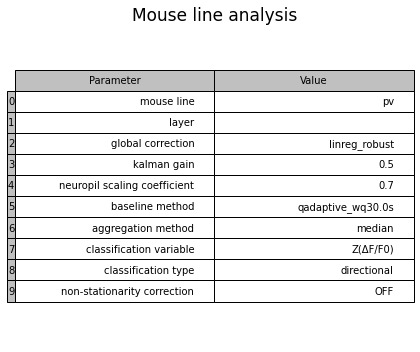

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'global correction': global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline method': baseline_id,
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'non-stationarity correction': 'ON' if do_nonstat_correct else 'OFF',
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [6]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

 2024/02/02 10:57:33: loading data from /gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main/pv:
 2024/02/02 10:57:33: gathering dataset IDs...
 2024/02/02 10:57:34: loading mouse-region data from 20190606_mouse2_region1.h5
 2024/02/02 10:57:34: loading mouse-region data from 20190606_mouse2_region2.h5
 2024/02/02 10:57:34: loading mouse-region data from 20190629_mouse2_region1.h5
 2024/02/02 10:57:34: loading mouse-region data from 20190630_mouse3_region1.h5
 2024/02/02 10:57:34: loading mouse-region data from 20190702_mouse1_region1.h5
 2024/02/02 10:57:34: loading mouse-region data from 20190702_mouse5_region1.h5
 2024/02/02 10:57:35: loading mouse-region data from 20190703_mouse4_region1.h5
 2024/02/02 10:57:35: loading mouse-region data from 20190821_mouse3_region1.h5
 2024/02/02 10:57:35: loading mouse-region data from 20190821_mous

### Unpack data and get ROI counts

In [7]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# # TEMPORAL FIX: Offset population-aggregated traces by their median values
# logger.warning('TEMP FIX: computing ΔF/F and z-score traces median values for each dataset & run...')
# ykeys_offset = [Label.DFF, Label.ZSCORE]
# ymeds = popagg_timeseries[ykeys_offset].groupby([Label.DATASET, Label.RUN]).median()
# logger.warning('TEMP FIX: offseting median values from traces...')
# popagg_timeseries[ykeys_offset] -= expand_to_match(ymeds, popagg_timeseries.index)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 2024/02/02 10:57:46: extracting timeseries and stats from data...
 2024/02/02 10:57:46: detailed ROI count:


run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190606_mouse2_region1,86,nan,nan,86,86,86,86,86,86,86,86,86,nan,nan,nan
20190606_mouse2_region2,106,nan,nan,106,106,106,106,106,106,106,106,106,nan,nan,nan
20190629_mouse2_region1,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111
20190630_mouse3_region1,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170
20190702_mouse1_region1,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196
20190702_mouse5_region1,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143
20190703_mouse4_region1,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112


### Inspect cell maps and exclude outlier datasets 

 2024/02/02 10:57:47: sorted cell densities:
dataset
20190606_mouse2_region1    338.593495
20190821_mouse3_region1    381.901965
20190606_mouse2_region2    417.336168
20190629_mouse2_region1    437.021836
20190703_mouse4_region1    440.958970
20190821_mouse7_region1    444.896103
20190702_mouse5_region1    563.010113
20190821_mouse6_region1    566.947247
20190630_mouse3_region1    669.312722
20190702_mouse1_region1    771.678197
dtype: float64
 2024/02/02 10:57:47: plotting cell maps...


100%|██████████| 10/10 [00:00<00:00, 66.33it/s]

 2024/02/02 10:57:47: no exclusion criterion -> ignoring


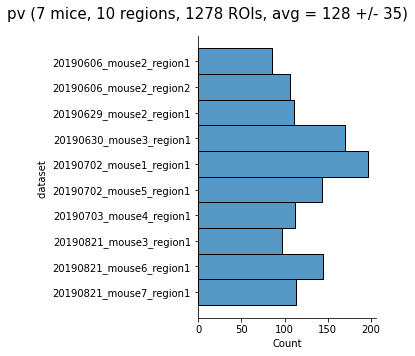

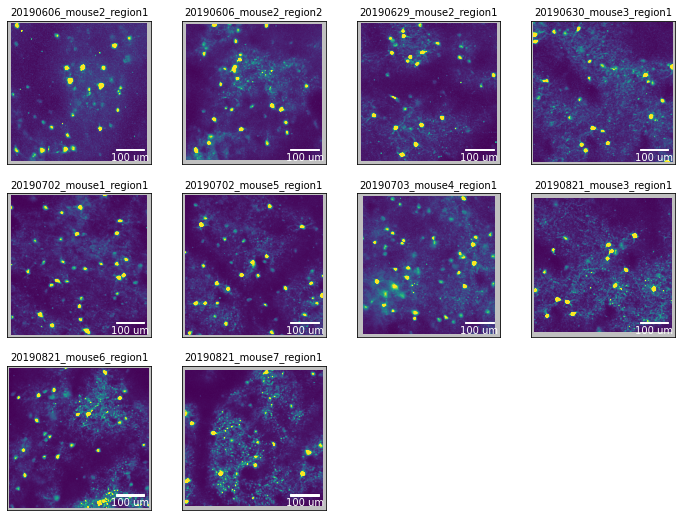

In [8]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# If threshold on cell density is specified, exclude datasets with densities below threshold 
from constants import MIN_CELL_DENSITY
outliers = None
if MIN_CELL_DENSITY[mouseline] is not None:
    isoutlier = ROI_densities < MIN_CELL_DENSITY[mouseline]
    outliers = isoutlier[isoutlier].index.values.tolist()
    if len(outliers) > 0:
        logger.warning(f'datasets with abnormally low cell density::\n{pprint.pformat(outliers)}')
    figs['cellcounts'].axes[0].axvline(
        MIN_CELL_DENSITY[mouseline] * FOV_areas.mean(), c='k', ls='--')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_fields_of_view(
    map_ops, 
    refkey='max_proj',
    # ROI_masks=ROI_masks, 
    Fstats=trialagg_stats, 
    mode='contour', 
    hue=None, 
    outliers=outliers,
    # qmin=.2,
    qmax=.99
)

# Exclude outlier datasets
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = filter_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, exclude=outliers)

### Inspect baseline variation throughout experiments and exclude outlier datasets

 2024/02/02 10:57:49: inspecting relative variations in baseline fluorescence across experiments...
 2024/02/02 10:57:49: maximal relative FO deviations:
dataset
20190630_mouse3_region1    0.045379
20190606_mouse2_region1    0.045463
20190606_mouse2_region2    0.046059
20190702_mouse1_region1    0.051029
20190821_mouse6_region1    0.061354
20190702_mouse5_region1    0.069364
20190703_mouse4_region1    0.120315
20190629_mouse2_region1    0.141263
20190821_mouse7_region1    0.144792
20190821_mouse3_region1    0.267499
Name: rel F0 (a.u.), dtype: float64


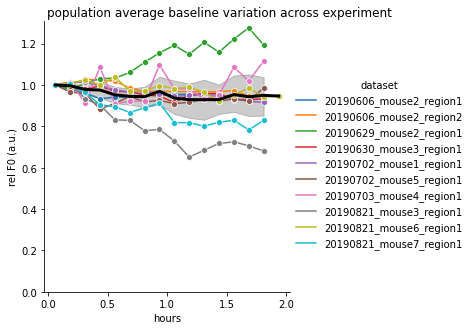

In [9]:
from constants import MAX_F0_REL_DEV
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Compute relative deviations of relative baseline fluorescence from its mean value,
# for each dataset
popagg_relF0_mean = popagg_F0_per_run[relF0_key].groupby(Label.DATASET).mean()
popagg_relF0_reldevs = ((popagg_F0_per_run[relF0_key] - popagg_relF0_mean) / popagg_relF0_mean).abs()

# Identify datasets that have at least 1 large F0 relative deviation from mean
max_popagg_relF0_reldevs = popagg_relF0_reldevs.groupby(Label.DATASET).max()
logger.info(f'maximal relative FO deviations:\n{max_popagg_relF0_reldevs.sort_values()}')
is_relF0_outlier = max_popagg_relF0_reldevs > MAX_F0_REL_DEV

# Extract datasets with at least 1 outlier run
relF0_outliers = is_relF0_outlier[is_relF0_outlier].index.unique(Label.DATASET).values.tolist()

# Remove potential outlier datasets
nouts = len(relF0_outliers)
palette = None
if nouts > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {nouts} datasets with abnormal baseline fluorescence variations:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = filter_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, exclude=relF0_outliers)
    palette = get_binary_palette(popagg_F0_per_run, relF0_outliers)

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    errorbar=None, 
    hue=Label.DATASET,
    marker='o',
    palette=palette,
    legend=palette is None,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    # ax.axhline(1 - MAX_F0_REL_VAR, ls='--', c='k')
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run.drop(relF0_outliers),
        lw=3, color='k', legend=False, **pltkwargs
    )

### Plot ROI / neuropil fluorescence ratio

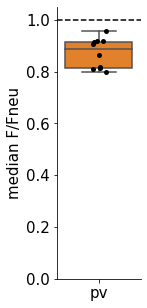

In [10]:
from plotters import plot_fluorescence_ratios
figs['F/Fneu'] = plot_fluorescence_ratios(popagg_timeseries, mouseline)

## Response curves

### Visualize global average trace, along with impact of exclusion criteria (on population-aggregated data)

 2024/02/02 10:57:52: plotting % of excluded samples per dataset, across criteria
 2024/02/02 10:57:52: computing population average data across (dataset, run, trial)...
 2024/02/02 10:57:52: ignoring object-typed columns ['response type'] in population average data
 2024/02/02 10:57:52: adding time info to table...
 2024/02/02 10:57:52: identifying conditions with >= 5 valid trials
 2024/02/02 10:57:52: adding expanded validity index to timeseries ...
 2024/02/02 10:57:53: filtering timeseries ...
 2024/02/02 10:57:53: identified 140/2240 (6.2%) samples with "discarded" tag
 2024/02/02 10:57:53: identifying conditions with >= 5 valid trials
 2024/02/02 10:57:53: adding expanded validity index to timeseries ...
 2024/02/02 10:57:53: filtering timeseries ...
 2024/02/02 10:57:54: identified 25/2240 (1.1%) samples with "motion" tag
 2024/02/02 10:57:54: identifying conditions with >= 5 valid trials
 2024/02/02 10:57:54: adding expanded validity index to timeseries ...
 2024/02/02 10:57:5

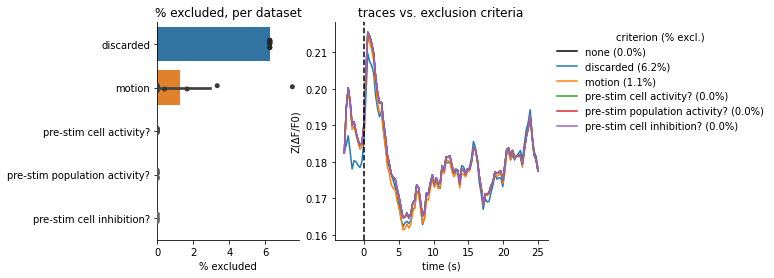

In [11]:
# Plot pct of exclusion per criterion and traces vs exclusion criteria
ykey = Label.ZSCORE
figs['impact of exclusion criteria'], axes = plt.subplots(
    1, 2, figsize=(7, 4), width_ratios=[1, 1.5])
plot_pct_excluded(ext_stats, ax=axes[0])
popagg_stats = get_popavg_data(ext_stats)
plot_traces_vs_exclusion(popagg_timeseries, popagg_stats, ykey, ax=axes[1]);

### Plot aggregate response trace for all non-zero conditions, and identify temporal response features and corresponding response analysis window

 2024/02/02 10:57:57: adding ['fps' 'duration (s)' 'P (MPa)' 'DC (%)' 'I_SPTA (W/cm2)'] information to timeseries...
 2024/02/02 10:58:01: adding time info to table...
 2024/02/02 10:58:02: plotting Z(ΔF/F0) response traces...
 2024/02/02 10:58:10: computing peak features on average trace...
 2024/02/02 10:58:10: response FWHM = 1.48s, corresponding window size = 1.40s (5 frames)
 2024/02/02 10:58:10: overwriting post window size in "/gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main/pv/post_window_size.txt"


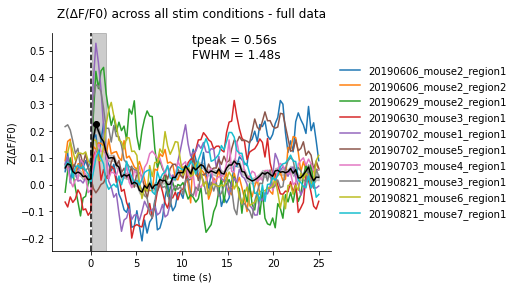

In [12]:
# Add critical stats columns to timeseries data
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Variable of interest
ykey = Label.ZSCORE

# Flag to add per-dataset traces
dataset_traces = 'full' # 'grey'

# Extract plot data for all non-zero conditions
stim_cond = plt_data[Label.ISPTA] > 0
stim_pltdata = plt_data[stim_cond]

# Plot average trace across datasets
logger.info(f'plotting {ykey} response traces...')
figs[f'{ykey} resp trace merged'], ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax)
if dataset_traces:
    sns.lineplot(
        ax=ax,
        data=stim_pltdata,
        x=Label.TIME,
        y=ykey,
        errorbar=None,
        hue=Label.DATASET,
        palette=get_uniform_palette(stim_pltdata) if dataset_traces == 'grey' else None,
        legend='full' if dataset_traces == 'full' else False,
    )
sns.lineplot(
    ax=ax,
    data=stim_pltdata,
    x=Label.TIME,
    y=ykey,
    errorbar='se',
    color='k' if dataset_traces == 'full' else Palette.LINE[mouseline],
)
ax.axvline(0, ls='--', c='k')
ax.set_title(f'{ykey} across all stim conditions - full data', y=1.05)

# Compute and materialize peak features on average trace
logger.info('computing peak features on average trace...')
fps = get_singleton(trialagg_stats, Label.FPS)
s = trialagg_timeseries[stim_cond][ykey].groupby(Label.FRAME).mean()
props = find_response_peak(
    s.loc[FrameIndex.STIM:], full_output=True, prominence=0.3 * np.ptp(s), width=1)
tprops = convert_peak_props(props, fps, ioffset=FrameIndex.STIM)
tpeak = tprops['index']  # s
ypeak = tprops['value']
FWHM = tprops['widths']  # s
ax.plot(tpeak, ypeak, 'o', c='k')
ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2, label='FWHM')

# Mark peak features on figure
txt = [
    f'tpeak = {tpeak:.2f}s',
    f'FWHM = {FWHM:.2f}s',
]

# Compute post-stimulus window size (i.e. number of frames) from extracted FWHM, and save it to file
npost = int(np.round(props['widths']))
logger.info(f'response FWHM = {FWHM:.2f}s, corresponding window size = {npost / fps:.2f}s ({npost} frames)')
save_post_window_size(input_dir, npost)

# Add text on axis and legend on right side
ax.text(0.5, 1, '\n'.join(txt), transform=ax.transAxes, va='top', fontsize=12)
if ax.get_legend() is not None:
    sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)

### Plot response traces for each parametric sweep (1 axis per condition)

 2024/02/02 10:58:11: plotting Z(ΔF/F0) vs. P (MPa) response traces...
 2024/02/02 10:58:24: plotting Z(ΔF/F0) vs. DC (%) response traces...


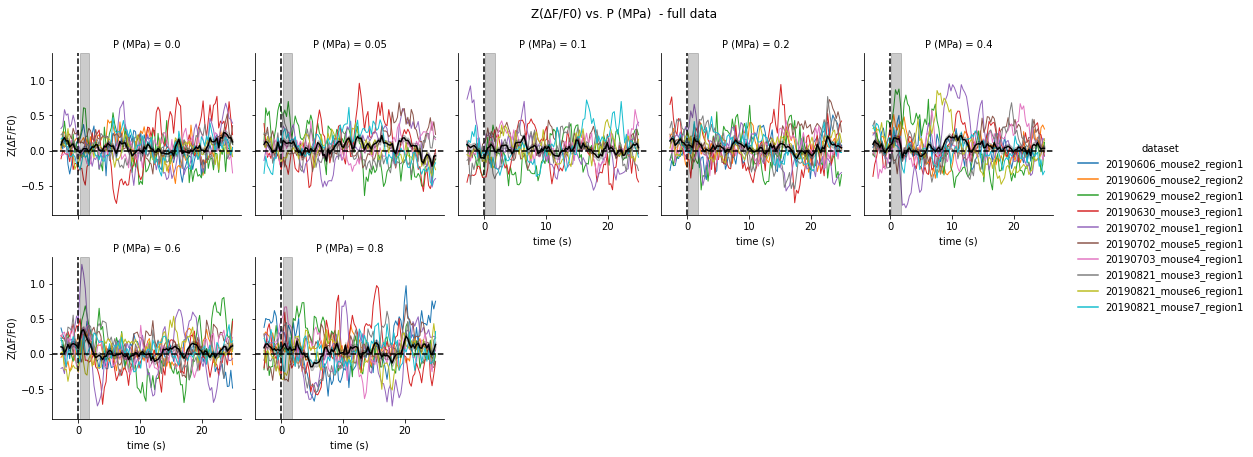

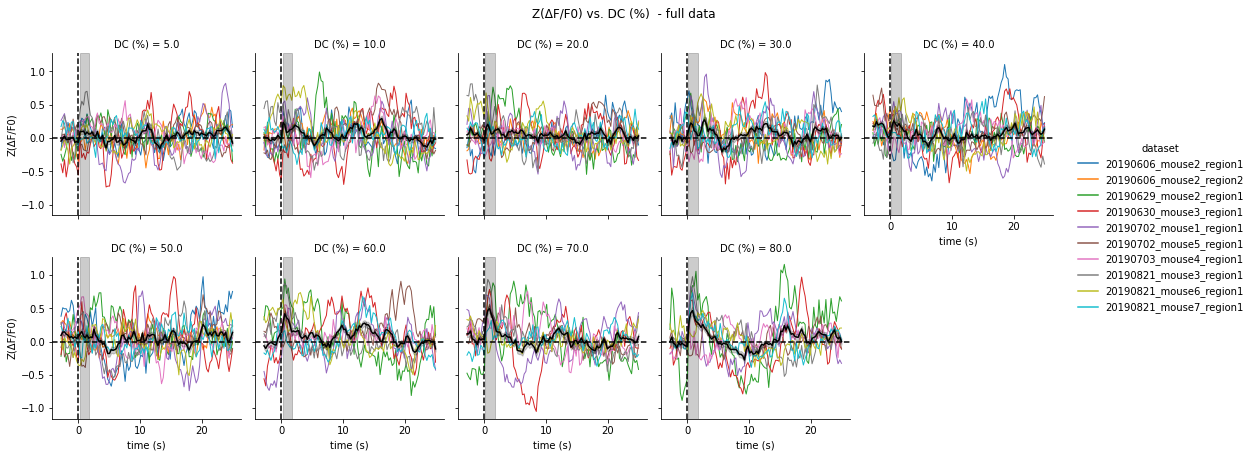

In [13]:
%%skip $skip_traces

# Variable of interest
ykey = Label.ZSCORE

# Flag to add per-dataset traces
dataset_traces = 'full'  # 'grey'

# Facetgrid kwargs
fgkwargs = dict(
    kind='line',
    col_wrap=5,
    height=3,
)

# For each input parameter
for xkey in [Label.P, Label.DC]:
    logger.info(f'plotting {ykey} vs. {xkey} response traces...')

    # Plot average traces for each dataset and sweep value, if requested
    if dataset_traces:
        # Plot average trace for each sweep value
        g = sns.relplot(
            data=get_xdep_data(plt_data, xkey),
            x=Label.TIME,
            y=ykey,
            col=xkey,
            hue=Label.DATASET,
            palette=get_uniform_palette(g.data) if dataset_traces == 'grey' else None,
            legend='full' if dataset_traces == 'full' else False,
            errorbar=None, 
            lw=1,
            zorder=-1,
            **fgkwargs
        )
    
    # Plot global average trace for each sweep value
    pltkwargs = dict(
        x=Label.TIME, 
        y=ykey,
        color='k' if dataset_traces == 'full' else Palette.LINE[mouseline],
        errorbar='se',
    )
    if dataset_traces:
        g.map_dataframe(sns.lineplot, **pltkwargs)
    else:
        g = sns.relplot(
            data=get_xdep_data(plt_data, xkey),
            col=xkey,
            **pltkwargs,
            **fgkwargs
        )
    
    # Add vertical line at stimulus onset, and horizontal line at 0 
    g.refline(x=0, y=0, c='k')
    for ax in g.axes:
        ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2)

    # Add title
    g.fig.suptitle(f'{ykey} vs. {xkey}  - full data', y=1.05)
    figs[f'{ykey} resp traces vs. {xkey} ext.'] = g.fig

### Plot response traces for each parametric sweep (1 axis per sweep)

 2024/02/02 10:58:44: sub-indexing data...
 2024/02/02 10:58:44: filtering data...
 2024/02/02 10:58:44: cross-checking filters...
 2024/02/02 10:58:44: grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2024/02/02 10:58:46: sub-indexing data...
 2024/02/02 10:58:46: filtering data...
 2024/02/02 10:58:46: cross-checking filters...
 2024/02/02 10:58:47: grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2024/02/02 10:58:49: sub-indexing data...
 2024/02/02 10:58:49: filtering data...
 2024/02/02 10:58:49: cross-checking filters...
 2024/02/02 10:58:49: grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 2024/02/02 10:58:52: sub-indexing data...
 2024/02/02 10:58:52: filtering data...
 2024/02/02 10:58:52: cross-checking filters...
 2024/02/02 10:58:52: grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


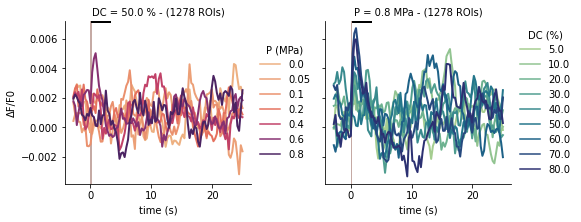

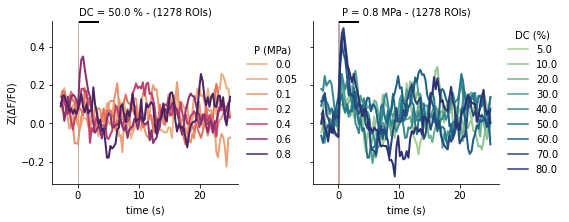

In [14]:
%%skip $skip_traces

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None #Label.ROI_RESP_TYPE

# # Align DFF and z-score traces w.r.t their pre-stimulus average
# plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
#     plt_data[[Label.DFF, Label.ZSCORE]], get_window_slice(kind='pre'))

# For each output variable
for ykey in ykeys_plt:

    # # Pressure-dependent and duty cycle dependent response traces, per dataset
    # for pkey in pkeys:
    #     figs.update(
    #         plot_responses_across_datasets(
    #             plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []
    if groupby is None:
        figs[f'{ykey} resp traces'], axes = plt.subplots(
            1, len(pkeys), figsize=(4 * len(pkeys), 3), 
            sharey=True, gridspec_kw=dict(wspace=.4))
    else:
        axes = [None] * len(pkeys)
    for pkey, ax in zip(pkeys, axes):
        fig = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, ax=ax, avg=True, groupby=groupby)
        if ax is not None:
            sns.move_legend(
                ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
        else:
            if isinstance(fig, dict):
                figs.update(fig)
            else:
                figs[f'{ykey} resp traces vs. {pkey}'] = fig
                avgaxes += fig.axes
    if len(avgaxes) > 0:
        harmonize_axes_limits(avgaxes, axkey='y')

## Parameter dependency curves

### Compute and plot initial parameter dependency curves with appropriate response window size

 2024/02/02 10:58:56: applying mean function on ΔF/F0 in [5-11] index window across dataset, ROI, run
 2024/02/02 10:58:56: applying mean function on ΔF/F0 in [11-16] index window across dataset, ROI, run
 2024/02/02 10:58:56: computing evoked ΔF/F0 change...
 2024/02/02 10:58:56: applying mean function on Z(ΔF/F0) in [5-11] index window across dataset, ROI, run
 2024/02/02 10:58:56: applying mean function on Z(ΔF/F0) in [11-16] index window across dataset, ROI, run
 2024/02/02 10:58:56: computing evoked Z(ΔF/F0) change...
 2024/02/02 10:58:56: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/02/02 10:58:56: sub-indexing data...
 2024/02/02 10:58:56: filtering data...
 2024/02/02 10:58:56: cross-checking filters...
 2024/02/02 10:58:56: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2024/02/02 10:58:56: sub-indexing data...
 2024/02/02 10:58:56: filtering data...
 2024/02/02 10:58:56: cross-ch

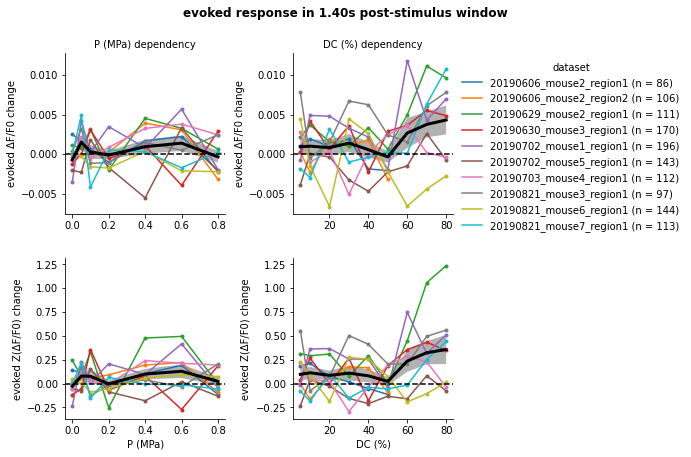

In [15]:
# Variables of interest
ykeys = [
    Label.DFF,
    Label.ZSCORE
]

# Whether to add detailed dataset traces
details = True

# Compute evoked responses for each variable of interest
for ykey in ykeys:
    ykey_diff = get_change_key(ykey)
    trialagg_stats[ykey_diff] = compute_evoked_change(
        trialagg_timeseries, 
        ykey, 
        npost=npost,  # Samples in determined post-stimulus window
    )

# Plot evoked response dependency on input parameters
figs['stimparams_init'] = plot_stimparams_dependency(
    trialagg_stats, 
    get_change_key(ykeys),
    xkeys=[Label.P, Label.DC],
    hue=Label.DATASET,
    palette='uniform' if not details else None,
    avgprop='whue', 
    avg_color='k' if details else 'line',
    errprop='inter',
    avgmarker='o',
    marker='.',
    errorbar=None,
)
figs['stimparams_init'].suptitle(
    f'evoked response in {npost / fps:.2f}s post-stimulus window', 
    fontsize=12, fontweight='bold', y=1.05)
if details:
    figs['stimparams_init'].subplots_adjust(wspace=.2)

### Inspect run presentation order per dataset and potential consequences on evoked activity

 2024/02/02 10:58:59: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 2024/02/02 10:58:59: run ID not part of (P (MPa), DC (%)) -> no filtering
 2024/02/02 10:58:59: sub-indexing data...
 2024/02/02 10:58:59: filtering data...
 2024/02/02 10:58:59: cross-checking filters...
 2024/02/02 10:58:59: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 2024/02/02 10:58:59: plotting evoked Z(ΔF/F0) change run sequence dependency across dataset...
 2024/02/02 10:58:59: run ID not part of (P (MPa), DC (%)) -> no filtering
 2024/02/02 10:58:59: sub-indexing data...
 2024/02/02 10:58:59: filtering data...
 2024/02/02 10:58:59: cross-checking filters...
 2024/02/02 10:58:59: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. run ID ...
 2024/02/02 10:58:59: adding sample counts per dataset on legend labels...
 2024/02/02 10:58:59: parameter sequences across datasets:


dataset,20190606_mouse2_region1,20190606_mouse2_region2,20190629_mouse2_region1,20190630_mouse3_region1,20190702_mouse1_region1,20190702_mouse5_region1,20190703_mouse4_region1,20190821_mouse3_region1,20190821_mouse6_region1,20190821_mouse7_region1
run ID,,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_40%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_30%DC,0.80MPa_40%DC,NaN,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_40%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.00MPa_50%DC,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,NaN,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.80MPa_60%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,NaN,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.20MPa_50%DC,0.20MPa_50%DC,0.80MPa_70%DC,0.20MPa_50%DC


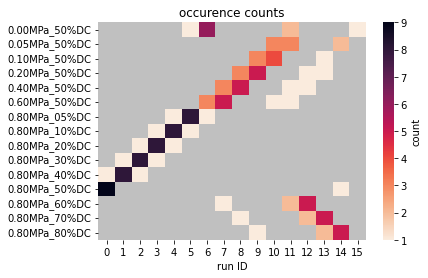

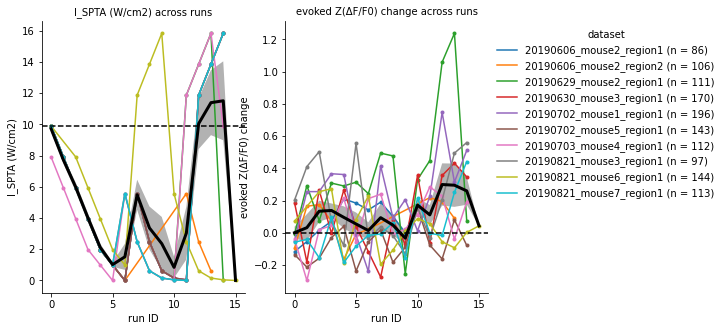

In [16]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
cmap = sns.color_palette('rocket_r', as_cmap=True)
cmap.set_under('silver')
sns.heatmap(
    data=params_counts, 
    ax=ax, 
    cmap=cmap, 
    cbar_kws={'label': 'count'},
    vmin=1,
)

# Plot Ispta and evoked response across run sequences, per dataset
ykeys_seq = [Label.ISPTA, ykey_diff]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(4 * len(ykeys_seq), 5))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        errorbar=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='.',
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Classify responses and responders

In [17]:
# Classify responses based on response z-score values
zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
    trialagg_stats[ykey_diff], zthr, directional=directional)

# TODO: classify responders

 2024/02/02 10:59:01: classifying responses using directional z-score thresholding ...


### Plot evoked change distribution for control condition (P = 0)

 2024/02/02 10:59:02: response type proportions at P = 0:
response type
weak        95.774648
positive     4.225352
Name: count, dtype: float64


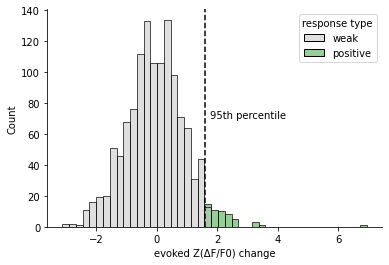

In [18]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
    hue_order=get_default_rtypes(),
    palette=Palette.RTYPE
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Extract dictionary of fits per input parameters for current mouse line 

In [19]:
fit_dict = get_fit_table()[mouseline]
logger.info(f'fit_dict:\n{fit_dict}')

 2024/02/02 10:59:02: fit_dict:
parameter
P (MPa)             scaled_power
DC (%)              scaled_power
P_SPTA (MPa)        scaled_power
P_SPTRMS (MPa)      scaled_power
I_SPTA (W/cm2)      scaled_power
I_SPTRMS (W/cm2)    scaled_power
Name: pv, dtype: object


### Plot parameter dependency curves, with fits

 2024/02/02 10:59:03: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/02/02 10:59:03: sub-indexing data...
 2024/02/02 10:59:03: filtering data...
 2024/02/02 10:59:03: cross-checking filters...
 2024/02/02 10:59:03: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2024/02/02 10:59:03: no significant P (MPa) dependency -> avoiding fit
 2024/02/02 10:59:03: sub-indexing data...
 2024/02/02 10:59:03: filtering data...
 2024/02/02 10:59:03: cross-checking filters...
 2024/02/02 10:59:03: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 2024/02/02 10:59:03: computing fit with scaled_power function: p0 = [5.4e-05, 1]
 2024/02/02 10:59:03: fitting results: popt = [3.9e-08, 2.7], R2 = 0.64
 2024/02/02 10:59:03: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/02/02 10:59:03: sub-indexing data...
 2024/02/02 10:59:03: filtering data...
 2024/02/02 1

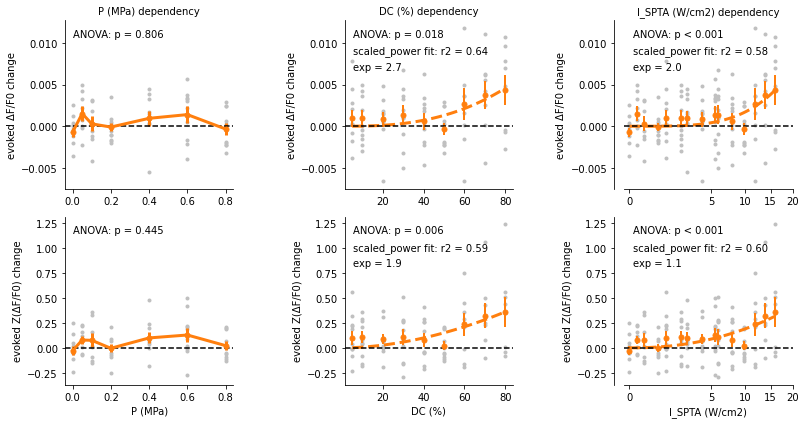

In [20]:
# Variables of interest
ykeys_resp = [get_change_key(k) for k in ykeys_plt] #+ [Label.RESP_FRAC]

# Plot evoked response dependency on input parameters, with fits
figs['stimparamdeps post curation'] = plot_stimparams_dependency(
    trialagg_stats,
    ykeys_resp,
    xkeys=xkeys_plt,  
    hue=Label.DATASET,
    palette='uniform',
    avgprop='whue', 
    avg_color='line',
    avgmarker='o',
    marker='.', 
    lw=0,
    errorbar=None,
    err_style='bars',
    fit=fit_dict,
)

### Plot P - DC alignment for various dose projections

 2024/02/02 10:59:06: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) "evoked ΔF/F0 change" series across run...
 2024/02/02 10:59:06: computing fit with scaled_power function: p0 = [0.0067, 1]
 2024/02/02 10:59:06: fitting results: popt = [0.015, 2.7], R2 = 0.70
 2024/02/02 10:59:06: computing fit with scaled_power function: p0 = [0.00027, 1]
 2024/02/02 10:59:06: fitting results: popt = [2.9e-06, 2.7], R2 = 0.70
 2024/02/02 10:59:06: computing fit with scaled_power function: p0 = [0.00028, 1]
 2024/02/02 10:59:06: fitting results: popt = [2.2e-09, 5.3], R2 = 0.70
 2024/02/02 10:59:06: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) "evoked Z(ΔF/F0) change" series across run...
 2024/02/02 10:59:07: computing fit with scaled_power function: p0 = [0.56, 1]
 2024/02/02 10:59:07: fitting results: popt = [0.83, 1.9], R2 = 0.68
 2024/02/02 10:59:07: computing fit with scaled_power function: p0 = [0.023, 1]
 2024/02/02 10:59:07: fitting results: pop

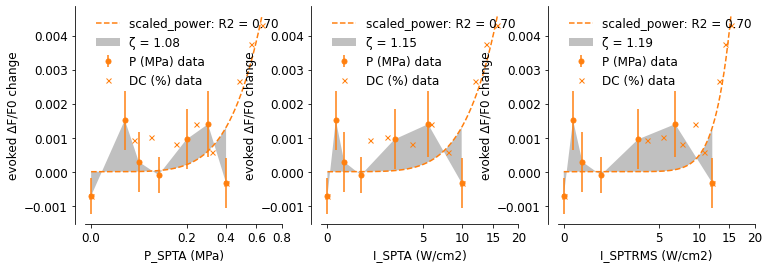

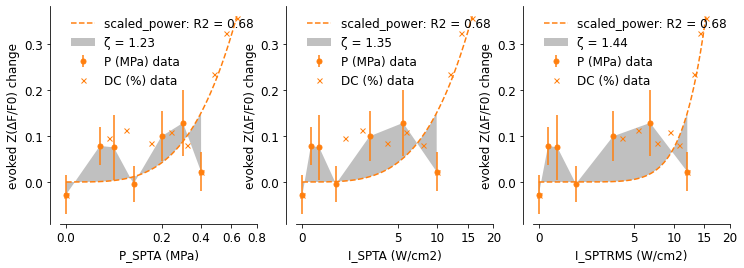

In [21]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Variables of interest
ykeys = [
    Label.DFF,
    Label.ZSCORE
]

# Dependent response variables
ykey_diffs = get_change_key(ykeys)

# Evaluate and plot alignment between DC sweep sigmoid predictors 
# and P sweep data
for ykey_diff in ykey_diffs:
    figs[f'resp alignment {ykey_diff}'] = plot_response_alignment(
        trialagg_stats,
        xkeys, 
        ykey_diff,
        fit_dict, 
        xscale='sqrt', 
        height=4,
    )   

### Comparison across layers (if applicable)

In [22]:
# dataset_ids = trialagg_stats.index.unique(Label.DATASET)
# layers = pd.Series(
#     [{True: 'layer5', False: 'layer2/3'}[s.endswith('layer5')] for s in dataset_ids],
#     index=dataset_ids,
#     name=Label.LAYER
# )
# logger.info(f'datasets count by layer:\n{layers.value_counts()}')
# if len(layers.value_counts()) > 1:
#     layer_palette = layers.map(
#         dict(zip(layers.unique(), mcolors.TABLEAU_COLORS.keys()))).to_dict()
#     trialagg_stats[Label.LAYER] = free_expand(layers, trialagg_stats)
#     fig = plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.DATASET,
#         hue_alpha=.5,
#         palette=layer_palette,
#         errorbar=None
#     )

#     plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.LAYER,
#         palette=layer_palette,
#         axes=np.array(fig.axes),
#         lw=10,
#         errorbar=None
#     )

## Analysis of Variance

 2024/02/02 11:00:37: performing 3-way ANOVA across datasets...


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]

 2024/02/02 11:01:15: adding 1-way ANOVA across datasets...


 2024/02/02 11:01:16: computing average ANOVA stats for each factor...


,df,SS,mean_sq,F,p-value,eta^2
factor,,,,,,
C(dataset),9.0,312.721281,34.746809,31.186123,3.470771e-55,0.000962
C(ROI),126.8,533.414107,4.200392,3.806062,9.411911e-09,0.016872
C(run),13.0,102.008372,7.596672,7.240628,6.817942e-04,0.003258
C(trial),15.0,116.762888,7.784193,7.873209,2.102061e-02,0.003477
C(run):C(trial),195.0,1235.163389,6.089771,5.946702,2.607002e-29,0.036043


 2024/02/02 11:01:16: plotting ANOVA stats across factors...


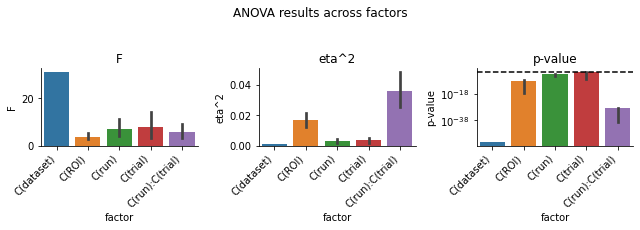

In [23]:
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm

# # Construct formula to perform 3-way ANOVA, with RUN:TRIAL interaction
# formula = f'y ~ C({Label.ROI}) + C({Label.RUN}) * C({Label.TRIAL})'

# # Iterate over datasets
# ANOVA_stats = {}
# logger.info('performing 3-way ANOVA across datasets...')
# for dataset, substats in tqdm(ext_stats.groupby(Label.DATASET)):
#     # Construct input dataframe
#     substats = substats[ykey_diff].rename('y').droplevel(Label.DATASET).reset_index()
#     # Construct/fit ANOVA model
#     model = ols(formula, data=substats).fit()
#     # Perform ANOVA
#     res = anova_lm(model)
#     # Rename columns and index
#     res = res.rename(columns={'sum_sq': 'SS', 'PR(>F)': 'p-value'})
#     res.index.name = 'factor'
#     # Compute and add effect size
#     res['eta^2'] = res['SS'] / (res['SS'] + res.loc['Residual', 'SS'])
#     res.loc['Residual', 'eta^2'] = np.nan
#     # Add ANOVA results to dictionary
#     ANOVA_stats[dataset] = res

# # Concatenate ANOVA stats across datasets
# ANOVA_stats = pd.concat(
#     ANOVA_stats, 
#     axis=0,
#     names=[Label.DATASET],
#     keys=ANOVA_stats.keys(),
# )

# # Swap index levels and sort by index
# ANOVA_stats = ANOVA_stats.swaplevel(0, 1).sort_index()

# # Add 1D ANOVA across datasets to ANOVA stats
# logger.info('adding 1-way ANOVA across datasets...')
# mux = (f'C({Label.DATASET})', 'all')
# ANOVA_stats.loc[mux, :] = anova1d(
#     ext_stats.reset_index(), 
#     Label.DATASET, 
#     ykey_diff, 
#     full_output=True
# ).iloc[0, :]
# ANOVA_stats.loc[mux, 'mean_sq'] = ANOVA_stats.loc[mux, 'SS'] / ANOVA_stats.loc[mux, 'df']

# # Average ANOVA stats across datasets, and display aggregate results
# logger.info('computing average ANOVA stats for each factor...')
# agg_ANOVA_stats = ANOVA_stats.groupby('factor').mean()
# factors_order = [
#     f'C({Label.DATASET})', 
#     f'C({Label.ROI})', 
#     f'C({Label.RUN})', 
#     f'C({Label.TRIAL})',
#     f'C({Label.RUN}):C({Label.TRIAL})',
# ]
# agg_ANOVA_stats = agg_ANOVA_stats.reindex(factors_order)
# display(agg_ANOVA_stats)

# # Plot ANOVA stats across factors
# pltkeys = ['F', 'eta^2', 'p-value']
# logger.info('plotting ANOVA stats across factors...')
# figs['manova'], axes = plt.subplots(1, len(pltkeys), figsize=(3 * len(pltkeys), 3))
# figs['manova'].suptitle('ANOVA results across factors', y=1.05)
# for ax, key in zip(axes, pltkeys):
#     sns.despine(ax=ax)
#     sns.barplot(
#         data=ANOVA_stats.drop(index='Residual', level='factor').reset_index(),
#         x='factor',
#         order=factors_order,
#         y=key,
#         ax=ax
#     )
#     ax.set_title(key)
#     for label in ax.get_xticklabels():
#         label.set_rotation(45)
#         label.set_ha('right')
#     if key == 'p-value':
#         ax.axhline(PTHR_DETECTION, ls='--', c='k')
#         ax.set_yscale('log')
# figs['manova'].tight_layout()

## State-dependence analysis

### Assess state-dependence of evoked activity

 2024/02/02 11:25:26: computing pairwise correlation coefficients...
 2024/02/02 11:25:26: computing pairwise correlation coefficients...
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original vs. shuffled: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.664e+03


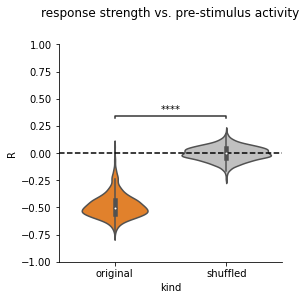

In [44]:
# Define variable of interest
ykey = Label.ZSCORE

# Extract pre, post and change keys
ykey_prestim, ykey_poststim, ykey_change = get_change_key(ykey, full_output=True)

# Define keys of variables to correlate / regress
xykeys = [
    ykey_prestim,
    ykey_change
]

# Define grouping categories
gby = [Label.DATASET, Label.ROI]

# Create dict of original and shuffled stats
statsdict = {
    'original': ext_stats,
    'shuffled': shuffle(ext_stats, key=ykey_prestim, gby=gby)
}

# Define color for each kind of stats
cdict = {
    'original': Palette.LINE[get_singleton(ext_stats, Label.LINE)],
    'shuffled': 'silver'
}

# Initialize list of axes
tmpaxes = []

# Initialize dict of correlation coefficients
corrcoeffs = {}

# For each stats kind
for kind, substats in statsdict.items():
    # # Plot pre-post distribution and associated statistics
    # figs[f'prepost corr {kind}'] = plot_correlation(
    #     substats, 
    #     *xykeys,
    #     color=cdict[kind],
    # )
    # figs[f'prepost corr {kind}'].suptitle(
    #     f'pre-post {ykey} distributions ({kind} data)', y=1.02)
    # # Add axes to list
    # tmpaxes = tmpaxes + figs[f'prepost corr {kind}'].axes

    # Compute Pearson correlation coefficient between pre-stimulus average and change
    logger.info('computing pairwise correlation coefficients...')
    corrcoeffs[kind] = (substats
        .groupby(gby)
        [xykeys]
        .corr()
        .droplevel(-1)
        .iloc[::2, 1]
        .rename('R')
    )

# # Harmonize axes limits
# harmonize_axes_limits(tmpaxes, axkey='xy')

# Convert correlation coefficients to dataframe
corrcoeffs = pd.concat(corrcoeffs, axis=0, keys=corrcoeffs.keys(), names=['kind'])

# Create violin plot comparison of correlation coefficients
figs['prepost corr. comparison'], ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
pltkwargs = dict(
    data=corrcoeffs.reset_index(),
    x='kind',
    y='R',
    palette=cdict,
)
sns.violinplot(**pltkwargs)
annotator = Annotator(ax, [('original', 'shuffled')], **pltkwargs)
annotator.configure(test='Mann-Whitney', loc='outside')
annotator.apply_and_annotate()
ax.set_ylim(-1, 1)
ax.axhline(0, ls='--', c='k')
ax.set_title('response strength vs. pre-stimulus activity', y=1.1);

### Assess impact of stimulus intensity on state dependence

 2024/02/02 11:23:22: computing pairwise correlation coefficients...
 2024/02/02 11:23:22: computing linear regression on pre-stim avg Z(ΔF/F0) and evoked Z(ΔF/F0) change...
 2024/02/02 11:23:24: computing pairwise correlation coefficients...
 2024/02/02 11:23:24: computing linear regression on pre-stim avg Z(ΔF/F0) and evoked Z(ΔF/F0) change...
 2024/02/02 11:23:26: plotting results vs ISPTA...


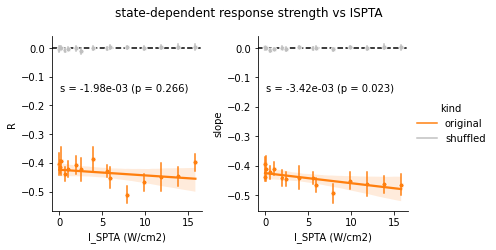

In [43]:
# Determine grouping categories
gby = [
    Label.ISPTA, 
    Label.DATASET, 
    # Label.ROI
]

# Create dict of original and shuffled stats
statsdict = {
    'original': ext_stats,
    'shuffled': shuffle(ext_stats, key=ykey_prestim, gby=gby)
}

# Initialize dict of output metrics
outmetrics = {}

# For original and shuffled stats
for kind, substats in statsdict.items():
    # Compute Pearson correlation coefficient between pre-stimulus average and change
    logger.info('computing pairwise correlation coefficients...')
    corrcoeffs = (substats
        .groupby(gby)
        [xykeys]
        .corr()
        .droplevel(-1)
        .iloc[::2, 1]
        .rename('R')
    )
    # Compute linear regression on pre-stimulus average and change
    logger.info(f'computing linear regression on {xykeys[0]} and {xykeys[1]}...')
    regres = (substats
        .groupby(gby)
        [xykeys]
        .apply(lambda df: apply_linregress(
            df, xkey=xykeys[0], ykey=xykeys[1], robust=True))
    )
    # Concatenate correlation coefficients and regression results
    outmetrics[kind] = pd.concat([corrcoeffs, regres], axis=1)

# Convert outputs to dataframe
outmetrics = pd.concat(outmetrics, axis=0, keys=outmetrics.keys(), names=['kind'])

# Plot results vs ISPTA
logger.info('plotting results vs ISPTA...')
keys = ['R', 'slope']
figs['prepost vs ISPTA'], axes = plt.subplots(1, len(keys), figsize=(3.5 * len(keys), 3.5))
figs['prepost vs ISPTA'].suptitle('state-dependent response strength vs ISPTA')
for i, (ax, key) in enumerate(zip(axes, keys)):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=outmetrics.reset_index(),
        x=Label.ISPTA,
        y=key,
        hue='kind',
        palette=cdict,
        err_style='bars',
        errorbar='se',
        marker='.',
        lw=0,
        markersize=10,
        legend=i == len(keys) - 1,
    )
    if ax.get_legend() is not None:
        sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
    robust = True
    sns.regplot(
        ax=ax,
        data=outmetrics.loc['original'].reset_index(),
        x=Label.ISPTA,
        y=key,
        color=cdict['original'],
        scatter=False,
        robust=robust,
    )
    df = apply_linregress(
        outmetrics.loc['original'],
        xkey=Label.ISPTA, 
        ykey=key, 
        robust=robust)
    ax.text(
        0.05, 0.7, f"s = {df['slope']:.2e} (p = {df['pval']:.3f})", 
        transform=ax.transAxes, ha='left', va='center')
    ax.axhline(0, ls='--', c='k', zorder=-1)
figs['prepost vs ISPTA'].tight_layout()

### ROI breakdown per dataset

 2024/02/02 11:25:40: computing fraction of response occurence per ROI over 9 "strong ISPTA" conditions...
 2024/02/02 11:25:41: identified 3.1% of responders with 0.5 as threshold proportion of responding conditions
 2024/02/02 11:25:41: plotting cell maps...


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


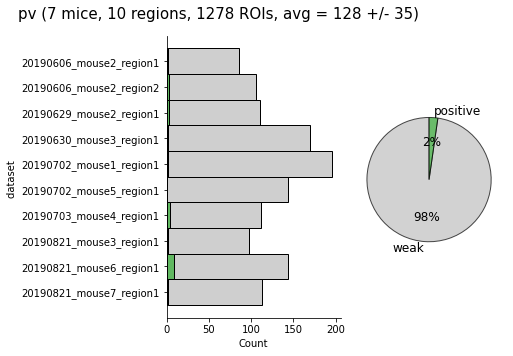

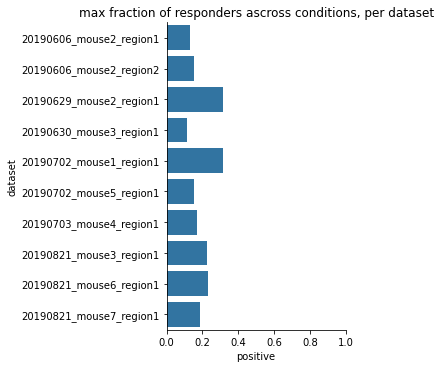

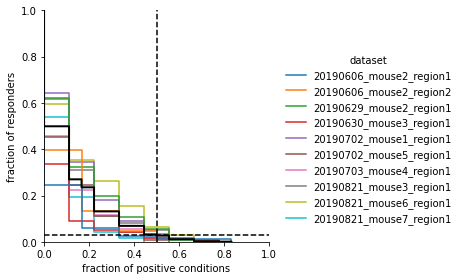

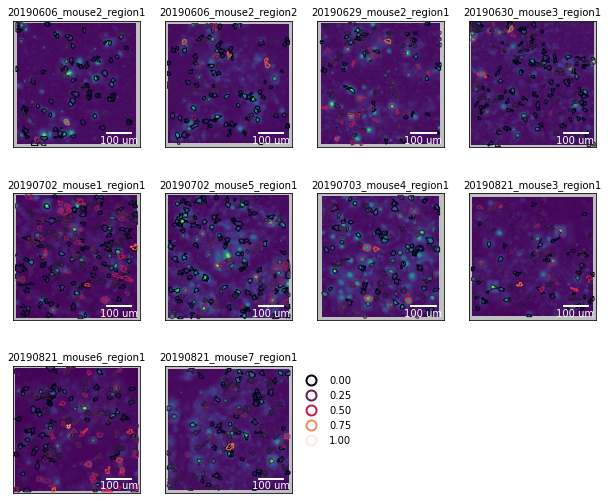

In [45]:
# Plot cell count distribution and breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_fields_of_view(
    map_ops, 
    ROI_masks=ROI_masks,
    Fstats=trialagg_stats, 
    refkey='Vcorr', 
    mode='contour', 
    hue='positive'
)

### Compute inter-ROI statistics

 2024/02/02 11:27:35: computing ROI centers...
 2024/02/02 11:27:35: computing pairwise distances between ROIs...
 2024/02/02 11:27:35: computing pairwise response correlations between ROIs...
 2024/02/02 11:27:36: assembling pairwise ROI stats dataframe...
 2024/02/02 11:27:36: plotting results


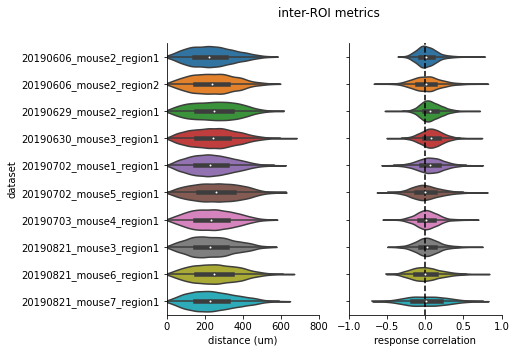

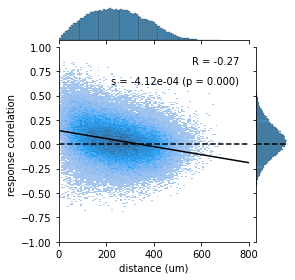

In [48]:
from scipy.spatial.distance import pdist, squareform

# Compute dataframe of ROIs "center of mass" coordinates
logger.info('computing ROI centers...')
gby = [Label.DATASET, Label.ROI]
weights = ROI_masks['lam']
wsum = weights.groupby(gby).sum()
ROI_centers = pd.DataFrame(index=wsum.index, columns=['x', 'y'])
for k in ['x', 'y']:
    ROI_centers[k] = (ROI_masks[f'{k}pix'] * weights).groupby(gby).sum() / wsum

# For each dataset, compute distance matrix between each ROI pair
logger.info('computing pairwise distances between ROIs...')
ROI_distances = {}
max_dists = pd.Series()
for dataset, coords in ROI_centers.groupby(Label.DATASET):
    coords = coords.droplevel(0)
    # Compute distance matrix
    dist = pd.DataFrame(
        data=squareform(pdist(coords, metric='euclidean')),
        index=coords.index,
        columns=coords.index
    )

    # Remove upper triangle (repeats) and diagonal (self-distances)
    dist = dist.where(np.triu(np.ones(dist.shape), k=1).astype(bool))

    # Serialize and remove self-distances
    dist = dist.unstack().dropna().rename('distance (pixels)')
    dist.index.names = ['ROI1', 'ROI2']

    # Convert to um
    um_per_pixel = map_ops[dataset]['micronsPerPixel']  # um/pix
    Lx, Ly = map_ops[dataset]['Lx'], map_ops[dataset]['Ly']
    dist = (dist * um_per_pixel).rename('distance (um)')

    # Compute maximal possible distance from FOV dimensions
    max_dists.loc[dataset] = np.sqrt(Lx**2 + Ly**2) * um_per_pixel
    
    # Append to dictionary
    ROI_distances[dataset] = dist

# Extract maximal possible distance across datasets, and round it to the nearest 100
dmax = max_dists.max()
dmax = np.ceil(dmax / 100) * 100

# Concatenate distance matrices
ROI_distances = pd.concat(ROI_distances, axis=0, keys=ROI_distances.keys(), names=[Label.DATASET])

# Compute cross-ROI correlations
logger.info('computing pairwise response correlations between ROIs...')
respcorrs = compute_crossROIs_correlations(
    ext_stats, ykey_diff, by=Label.DATASET).rename('response correlation')

# Assemble pairwise ROI stats dataframe
logger.info('assembling pairwise ROI stats dataframe...')
pairwise_ROI_stats = pd.concat([ROI_distances, respcorrs], axis=1)

logger.info('plotting results')

# Plot distributions of each pairwise, per dataset
keys = pairwise_ROI_stats.columns
ndatasets = len(pairwise_ROI_stats.index.unique(Label.DATASET))
figs['inter ROI metrics'], axes = plt.subplots(1, len(keys), figsize=(3 * len(keys), 0.5 * ndatasets))
figs['inter ROI metrics'].suptitle('inter-ROI metrics')
for i, (ax, k) in enumerate(zip(axes, keys)):
    sns.despine(ax=ax)
    sns.violinplot(
        data=pairwise_ROI_stats.reset_index(),
        x=k,
        y=Label.DATASET,
        split=True,
        cut=0,
        ax=ax
    )
    if i > 0:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    if k == 'response correlation':
        ax.set_xlim(-1, 1)
        ax.axvline(0, ls='--', c='k')
    elif k == 'distance (um)':
        ax.set_xlim(0, dmax)

# Plot joint distribution of distance and response correlation
jg = sns.jointplot(
    data=pairwise_ROI_stats, 
    x='distance (um)', 
    y='response correlation',
    kind='hist',
    height=4,
)
jg.ax_joint.set_xlim(0, dmax)
jg.ax_joint.set_ylim(-1, 1)
for ax in [jg.ax_joint, jg.ax_marg_y]:
    ax.axhline(0., ls='--', c='k')
R = pairwise_ROI_stats.corr().iloc[0, 1]
jg.ax_joint.text(0.95, 0.95, f'R = {R:.2f}', transform=jg.ax_joint.transAxes, ha='right', va='top')
regres = apply_linregress(
    pairwise_ROI_stats, 
    xkey='distance (um)', 
    ykey='response correlation',
    robust=True,
)
dvec = np.array([0, dmax])
jg.ax_joint.plot(dvec, regres['slope'] * dvec + regres['intercept'], 'k')
jg.ax_joint.text(
    0.95, 0.85, f's = {regres["slope"]:.2e} (p = {regres["pval"]:.3f})', 
    transform=jg.ax_joint.transAxes, ha='right', va='top')
figs['ROI respcorr vs distance'] = jg.fig

### Plot trial heatmap per condition for entire mouse line

In [49]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_activity_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

## Exports

### Save responder-type-averaged stats to disk

In [50]:
# Define resp prop extraction function
respprops_func = lambda df: get_responders_counts(
    df, Label.RUN, units=Label.DATASET, normalize=True)

# Get resp fractions by dataset, run and responder type
resp_props_by_type = trialagg_stats.groupby(Label.ROI_RESP_TYPE).apply(respprops_func)
weights = resp_props_by_type.pop('weight')
weighted_resp_props = resp_props_by_type.multiply(weights, axis=0).groupby([Label.ROI_RESP_TYPE, Label.RUN]).sum()
resp_props_sem = resp_props_by_type.groupby([Label.ROI_RESP_TYPE, Label.RUN]).sem()
resp_frac_by_type = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Get overall resp fractions by dataset and run
resp_props_all = respprops_func(trialagg_stats)
weights = resp_props_all.pop('weight')
weighted_resp_props = resp_props_all.multiply(weights, axis=0).groupby(Label.RUN).sum()
resp_props_sem = resp_props_all.groupby(Label.RUN).sem()
resp_frac_all = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Merge the two datasets
resp_frac_stats = (
    pd.concat([
        resp_frac_by_type, 
        resp_frac_all
            .assign(**{Label.ROI_RESP_TYPE: 'all'})
            .set_index(Label.ROI_RESP_TYPE, append=True)
            .reorder_levels([Label.ROI_RESP_TYPE, Label.RUN])
    ], axis=0)
    .add_prefix(f'{Label.RESP_FRAC} - ')
)

# Extract output directory for line-aggregated data
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)

# For each error propagation type
for errprop in ['intra', 'inter']:
    # Determine output file path
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    # Extract line-aggregated data
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    # Add information about responder types
    lineagg_stats = pd.concat([lineagg_stats, resp_frac_stats], axis=1)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

# Add information about cell count per dataset
nROIs_per_dataset = (get_detailed_ROI_count(trialagg_stats)
    .max(axis=1)
    .astype(int)
    .rename(Label.ROI_COUNT)
    .to_frame()
    .assign(line=mouseline)
    .set_index(Label.LINE, append=True)
)
fpath = os.path.join(lineagg_dir, f'{mouseline}_counts.csv')
nROIs_per_dataset.to_csv(fpath)

 2024/02/02 11:35:35: run not part of (P (MPa), DC (%)) -> no filtering
 2024/02/02 11:35:35: run not part of (P (MPa), DC (%)) -> no filtering
 2024/02/02 11:35:35: run not part of (P (MPa), DC (%)) -> no filtering
 2024/02/02 11:35:35: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/02/02 11:35:35: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/02/02 11:35:36: saving line-aggregated stats to /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main/pv_intra.csv...
 2024/02/02 11:35:36: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/02/02 11:35:36: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/02/02 11:35:36: saving line-aggregated stats to

### Save figures

In [30]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2024/02/01 17:54:32: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.02.01/figs_main_pv_linreg_robust_k0.5_alpha0.7_qadaptive_wq30.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


### Notify upon completion

In [31]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/02/01 17:54:51: pv batch notebook completed in 0:03:41.759353 s
